In [1]:
import pandas as pd
import csv
import numpy as np

df = pd.read_csv("Dataset(SMOTE).csv", low_memory=False)
df

,label,file_access,pe_imports,sig_clamav,pe_sec_character,sig_antivirus_virustotal,cmd_exec,api_resolv,pe_sec_entropy,pe_sec_name,...,sig_antianalysis_detectfile,sig_network_cnc_http,sig_removes_zoneid_ads,sig_downloader_cabby,sig_sniffer_winpcap,sig_creates_largekey,sig_infostealer_bitcoin,sig_static_detection,sig_antiav_servicestop,sig_recon_beacon
0,0,764,129,560,81,2280,102,1302,1147,211,...,2,12,5,2,2,3,0,231,4,11
1,0,984,129,560,81,2018,112,1302,1147,211,...,2,12,5,2,2,3,0,231,4,11
2,0,2164,1394,560,77,2018,541,237,124,207,...,2,12,5,2,2,3,0,231,4,11
3,0,946,962,560,81,2214,527,1212,183,211,...,2,12,5,2,2,3,0,231,4,11
4,0,1743,1345,560,77,216,144,634,73,207,...,2,12,5,2,2,3,0,231,4,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10095,4,666,561,560,106,852,541,634,2102,232,...,2,12,5,2,2,3,0,230,4,11
10096,4,1099,427,560,107,2018,541,634,309,233,...,2,12,5,2,2,3,0,231,4,11
10097,4,1856,1407,560,81,1573,541,639,1626,211,...,2,12,5,2,2,3,0,71,4,11
10098,4,1846,1373,560,102,331,541,634,1354,230,...,2,12,5,2,2,3,0,118,4,11


In [2]:
from sklearn.model_selection import train_test_split

# Separating the features from the target variable
X = df.iloc[:, 1:65]
y = df['label']

# Splitting the data into a train and a dev set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 0) 

In [3]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(criterion='gini',max_depth=12, max_features='sqrt',
                             min_samples_split=10, n_estimators=200, random_state=0)

boruta_selector = BorutaPy(rfc, n_estimators='auto', verbose=2, random_state=0)

boruta_selector.fit(np.array(X_train), np.array(y_train))

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	64
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	64
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	64
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	64
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	64
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	64
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	64
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	29
Tentative: 	5
Rejected: 	30
Iteration: 	9 / 100
Confirmed: 	29
Tentative: 	5
Rejected: 	30
Iteration: 	10 / 100
Confirmed: 	29
Tentative: 	5
Rejected: 	30
Iteration: 	11 / 100
Confirmed: 	29
Tentative: 	5
Rejected: 	30
Iteration: 	12 / 100
Confirmed: 	30
Tentative: 	4
Rejected: 	30
Iteration: 	13 / 100
Confirmed: 	30
Tentative: 	2
Rejected: 	32


KeyboardInterrupt: 

In [ ]:
# Using the BorutaPy object to transform the features in the dataset.
X_important_train = boruta_selector.transform(np.array(X_train))
X_important_test = boruta_selector.transform(np.array(X_test)) 

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf_boruta = RandomForestClassifier(random_state=0)

# Defining search space from which grid serch will select a model which will give the best result.
param_grid = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': [200, 300, 400],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [8, 10, 12],
    'min_samples_split': [2, 5, 10]
}

# Making an object grid_GBC for GridSearchCV and fitting the dataset
grid_rf = GridSearchCV(rf_boruta, param_grid, refit=True, n_jobs=-1, cv=10, verbose=3, scoring='accuracy')
grid_rf.fit(X_important_train, y_train)

# Print best parameters and accuracy score
print("Best parameters found: ", grid_rf.best_params_)
print("Best accuracy score found: {:.4f}".format(grid_rf.best_score_))

Fitting 10 folds for each of 108 candidates, totalling 1080 fits
Best parameters found:  {'criterion': 'gini', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 300}
Best accuracy score found: 0.8392


In [7]:
#  Give best model as a result
rf_model = grid_rf.best_estimator_
rf_model

RandomForestClassifier(max_depth=12, min_samples_split=10, n_estimators=300,
                       random_state=0)

In [8]:
from sklearn.ensemble import RandomForestClassifier

# Instantiate model
rfc1 = RandomForestClassifier(criterion='gini',max_depth=12, max_features='sqrt',
                              min_samples_split=10, n_estimators=300, random_state=0)

# Train the model on training data
rfc1.fit(X_important_train, y_train)

# Use the forest's predict method on the test data
rfc_predict = rfc1.predict(X_important_test)

In [9]:
from sklearn import metrics

# Accuracy
print(metrics.accuracy_score(y_test, rfc_predict))
# Precision
print(metrics.precision_score(y_test, rfc_predict, average='macro'))
# Recall
print(metrics.recall_score(y_test, rfc_predict, average='macro'))
# F1 Score
print(metrics.f1_score(y_test, rfc_predict, average='macro'))

0.8539603960396039
0.8540171830550711
0.8496130603101169
0.8477550423177529


C:\Users\user\AppData\Local\Temp\ipykernel_1252\3015791322.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(a)
C:\Users\user\AppData\Local\Temp\ipykernel_1252\3015791322.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(b)


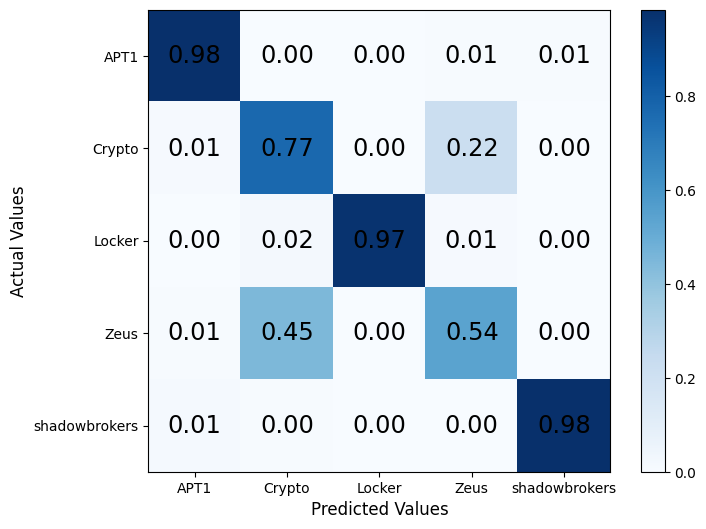

In [10]:
import matplotlib.pyplot as plt

# Confusion Matrix
conf_matrix = metrics.confusion_matrix(y_test, rfc_predict, normalize = 'true')

fig, ax = plt.subplots(figsize=(8, 6))
caxes = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
fig.colorbar(caxes)
fmt = '.2f'
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=format(conf_matrix[i, j], fmt), va='center', ha='center', size='xx-large')

a=ax.get_xticks().tolist()
a[1]='APT1'
a[2]='Crypto'
a[3]='Locker'
a[4]='Zeus'
a[5]='shadowbrokers'

b=ax.get_yticks().tolist()
b[1]='APT1'
b[2]='Crypto'
b[3]='Locker'
b[4]='Zeus'
b[5]='shadowbrokers'
ax.set_xticklabels(a)
ax.set_yticklabels(b)

plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Actual Values', fontsize=12)
plt.gca().xaxis.tick_bottom()
plt.show()

In [3]:
from sklearn.ensemble import RandomForestClassifier

# Instantiate model with 100 decision trees
rfc2 = RandomForestClassifier(criterion='gini',max_depth=12, max_features='sqrt',
                              min_samples_split=10, n_estimators=200, random_state=0)

# Train the model on training data
rfc2.fit(X_train, y_train)

# Use the forest's predict method on the test data
rfc2_predict = rfc2.predict(X_test)

# Export the predicted values
np.savetxt("RF_Imbalanced(80-20).csv", rfc2_predict, delimiter=",")

In [12]:
from sklearn import metrics

# Accuracy
print(metrics.accuracy_score(y_test, rfc2_predict))
# Precision
print(metrics.precision_score(y_test, rfc2_predict, average='macro'))
# Recall
print(metrics.recall_score(y_test, rfc2_predict, average='macro'))
# F1 Score
print(metrics.f1_score(y_test, rfc2_predict, average='macro'))

0.8425742574257425
0.8420704580629372
0.8378297938081884
0.8352226318080913


C:\Users\user\AppData\Local\Temp\ipykernel_1252\106375199.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(a)
C:\Users\user\AppData\Local\Temp\ipykernel_1252\106375199.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(b)


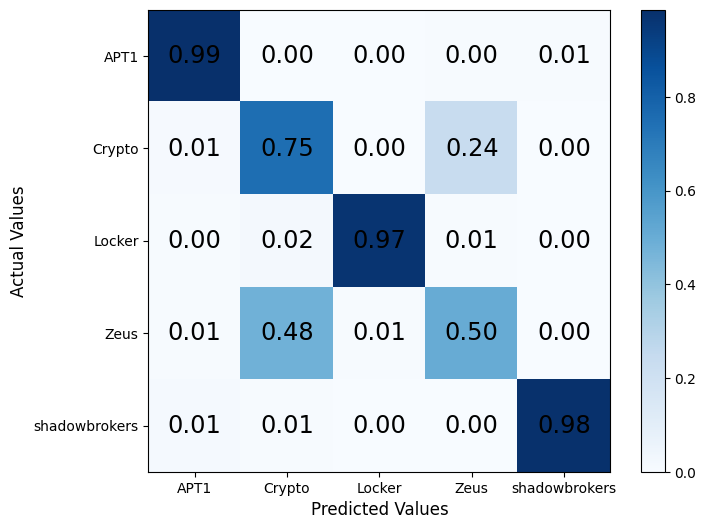

In [13]:
import matplotlib.pyplot as plt

# Confusion Matrix
conf_matrix = metrics.confusion_matrix(y_test, rfc2_predict, normalize = 'true')

fig, ax = plt.subplots(figsize=(8, 6))
caxes = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
fig.colorbar(caxes)
fmt = '.2f'
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=format(conf_matrix[i, j], fmt), va='center', ha='center', size='xx-large')

a=ax.get_xticks().tolist()
a[1]='APT1'
a[2]='Crypto'
a[3]='Locker'
a[4]='Zeus'
a[5]='shadowbrokers'

b=ax.get_yticks().tolist()
b[1]='APT1'
b[2]='Crypto'
b[3]='Locker'
b[4]='Zeus'
b[5]='shadowbrokers'
ax.set_xticklabels(a)
ax.set_yticklabels(b)

plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Actual Values', fontsize=12)
plt.gca().xaxis.tick_bottom()
plt.show()